In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
# map rendering library
import folium 

import lxml.html as lh

# NMF
from sklearn.decomposition import NMF 

# Data Collection

## New York data

In [344]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

Data downloaded!


In [345]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [346]:
neighborhoods_data = newyork_data['features']

In [347]:
# instantiate the dataframe
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
NY_dataset = pd.DataFrame(columns=column_names)

In [348]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_dataset = NY_dataset.append({'Borough': borough,
                                    'Neighborhood': neighborhood_name,
                                    'Latitude': neighborhood_lat,
                                    'Longitude': neighborhood_lon}, ignore_index=True)

In [349]:
NY_dataset.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [350]:
NY_dataset.shape

(306, 4)

New York Venue data will be obtained after data cleaning.

## Toronto data

City of Toronto data is from the open data of City of Toronto website (Source https://www.toronto.ca/).

In [453]:
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=csv&projection=2019'
TO_dataset = pd.read_csv(url)

The sample of City of Toronto data.

In [353]:
TO_dataset.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,2661,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),NaN,NaN,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{u'type': u'Polygon', u'coordinates': (((30996..."
1,2662,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),NaN,NaN,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{u'type': u'Polygon', u'coordinates': (((31197..."
2,2663,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),NaN,NaN,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{u'type': u'Polygon', u'coordinates': (((31357..."
3,2664,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),NaN,NaN,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{u'type': u'Polygon', u'coordinates': (((30437..."
4,2665,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),NaN,NaN,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{u'type': u'Polygon', u'coordinates': (((30966..."


The dimension of City of Toronto data.

In [352]:
TO_dataset.shape

(140, 16)

Toronto Venue data will be obtained after data cleaning.

# Data Cleaning

## New York data

Create a feature that combines original features *Borough* and *Neighobrhood*.

In [354]:
Neighborhood = NY_dataset.Borough + ', ' + NY_dataset.Neighborhood
# Drop feature 'Borough'
NY_dataset.drop('Borough', axis=1, inplace=True)
# Modify feature 'Neighborhood'
NY_dataset['Neighborhood'] = Neighborhood

In [355]:
NY_dataset.head()

,Neighborhood,Latitude,Longitude
0,"Bronx, Wakefield",40.894705,-73.847201
1,"Bronx, Co-op City",40.874294,-73.829939
2,"Bronx, Eastchester",40.887556,-73.827806
3,"Bronx, Fieldston",40.895437,-73.905643
4,"Bronx, Riverdale",40.890834,-73.912585


Check whether each neighborhood is unique.

In [359]:
len(NY_dataset.Neighborhood.unique()) == NY_dataset.shape[0]

True

The number of observations in New York dataset matches the unique number of observations. There is no duplicate.

Acquire venue categories data of neighborhoods in New York using Foursqure API.

Specifically, we restrict the maximal number of venues for each neighborhood to be 100 and restrict the venues within 500 meters of the location of each neighborhood.

In [360]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [364]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
with open('ID.txt', 'r') as file:
    data = file.read().replace('\n', '')
ID = data[:48]
secret = data[48:]

In [483]:
CLIENT_ID = ID # your Foursquare ID
CLIENT_SECRET = secret # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [382]:
NY_venues = getNearbyVenues(names=NY_dataset['Neighborhood'],
                                 latitudes=NY_dataset['Latitude'],
                                 longitudes=NY_dataset['Longitude'])

Bronx, Wakefield
Bronx, Co-op City
Bronx, Eastchester
Bronx, Fieldston
Bronx, Riverdale
Bronx, Kingsbridge
Manhattan, Marble Hill
Bronx, Woodlawn
Bronx, Norwood
Bronx, Williamsbridge
Bronx, Baychester
Bronx, Pelham Parkway
Bronx, City Island
Bronx, Bedford Park
Bronx, University Heights
Bronx, Morris Heights
Bronx, Fordham
Bronx, East Tremont
Bronx, West Farms
Bronx, High  Bridge
Bronx, Melrose
Bronx, Mott Haven
Bronx, Port Morris
Bronx, Longwood
Bronx, Hunts Point
Bronx, Morrisania
Bronx, Soundview
Bronx, Clason Point
Bronx, Throgs Neck
Bronx, Country Club
Bronx, Parkchester
Bronx, Westchester Square
Bronx, Van Nest
Bronx, Morris Park
Bronx, Belmont
Bronx, Spuyten Duyvil
Bronx, North Riverdale
Bronx, Pelham Bay
Bronx, Schuylerville
Bronx, Edgewater Park
Bronx, Castle Hill
Bronx, Olinville
Bronx, Pelham Gardens
Bronx, Concourse
Bronx, Unionport
Bronx, Edenwald
Brooklyn, Bay Ridge
Brooklyn, Bensonhurst
Brooklyn, Sunset Park
Brooklyn, Greenpoint
Brooklyn, Gravesend
Brooklyn, Brighton Bea

In [385]:
NY_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bronx, Wakefield",40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,"Bronx, Wakefield",40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,"Bronx, Wakefield",40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,"Bronx, Wakefield",40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,"Bronx, Wakefield",40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [386]:
NY_venues.shape

(10229, 7)

Check the unique number of neighborhoods in New York venues data.

In [387]:
print('the unique number of neighborhoods in New York venues data:', len(NY_venues.Neighborhood.unique()))
print('the unique number of neighborhoods in New York data', len(NY_dataset.Neighborhood.unique()))

the unique number of neighborhoods in New York venues data: 305
the unique number of neighborhoods in New York data 306


The unique number of neighborhoods in New York data does not match that in New York venues data.

In [388]:
set(NY_dataset.Neighborhood).difference(set(NY_venues.Neighborhood))

{'Staten Island, Howland Hook'}

Extract this observaton out from New York data.

In [389]:
obs = NY_dataset[NY_dataset.Neighborhood=='Staten Island, Howland Hook']
obs

,Neighborhood,Latitude,Longitude
257,"Staten Island, Howland Hook",40.638433,-74.186223


In [403]:
for lat, lng in zip(obs.Latitude, obs.Longitude):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e06e1a99fcb92001cd2d66f'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 0,
  'suggestedBounds': {'ne': {'lat': 40.642932842447955,
    'lng': -74.18030423787997},
   'sw': {'lat': 40.63393283344795, 'lng': -74.1921423971165}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': []}]}}

It seems Foursquare API cannot provides enough venues to us based on such coordinates.

We decide to use *GeoPy* library to find the more accruate coordiante of 'Staten Island, Howland Hook'.

In [404]:
address = 'Howland Hook, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lon = location.longitude
print("latitude is", lat, 'longitude is', lon)

latitude is 40.6433809 longitude is -74.1824535


In [406]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            500, 
            100)
results = requests.get(url).json()
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '55e3f470498e7eb42f2f9746',
   'name': 'Howland Hook',
   'location': {'lat': 40.642357,
    'lng': -74.186573,
    'labeledLatLngs': [{'label': 'display',
      'lat': 40.642357,
      'lng': -74.186573}],
    'distance': 366,
    'cc': 'US',
    'city': 'Staten Island',
    'state': 'NY',
    'country': 'United States',
    'formattedAddress': ['Staten Island, NY', 'United States']},
   'categories': [{'id': '52e81612bcbc57f1066b7a0f',
     'name': 'Fishing Spot',
     'pluralName': 'Fishing Spots',
     'shortName': 'Fishing Spot',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_fishmarket_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-55e3f470498e7eb42f2f9746-0'},
 {'reasons': {'count': 0,
   'items': [{'summary': 'This spot 

By using more accurate coordinate, it works.

We reconstruct New York venues data.

In [416]:
ind = int(NY_dataset[NY_dataset.Neighborhood=='Staten Island, Howland Hook'].index.values)
NY_dataset.iloc[ind,1] = lat
NY_dataset.iloc[ind,2] = lon

In [418]:
NY_dataset[NY_dataset.Neighborhood=='Staten Island, Howland Hook']

,Neighborhood,Latitude,Longitude
257,"Staten Island, Howland Hook",40.643381,-74.182453


In [419]:
NY_venues = getNearbyVenues(names=NY_dataset['Neighborhood'],
                                 latitudes=NY_dataset['Latitude'],
                                 longitudes=NY_dataset['Longitude'])

Bronx, Wakefield
Bronx, Co-op City
Bronx, Eastchester
Bronx, Fieldston
Bronx, Riverdale
Bronx, Kingsbridge
Manhattan, Marble Hill
Bronx, Woodlawn
Bronx, Norwood
Bronx, Williamsbridge
Bronx, Baychester
Bronx, Pelham Parkway
Bronx, City Island
Bronx, Bedford Park
Bronx, University Heights
Bronx, Morris Heights
Bronx, Fordham
Bronx, East Tremont
Bronx, West Farms
Bronx, High  Bridge
Bronx, Melrose
Bronx, Mott Haven
Bronx, Port Morris
Bronx, Longwood
Bronx, Hunts Point
Bronx, Morrisania
Bronx, Soundview
Bronx, Clason Point
Bronx, Throgs Neck
Bronx, Country Club
Bronx, Parkchester
Bronx, Westchester Square
Bronx, Van Nest
Bronx, Morris Park
Bronx, Belmont
Bronx, Spuyten Duyvil
Bronx, North Riverdale
Bronx, Pelham Bay
Bronx, Schuylerville
Bronx, Edgewater Park
Bronx, Castle Hill
Bronx, Olinville
Bronx, Pelham Gardens
Bronx, Concourse
Bronx, Unionport
Bronx, Edenwald
Brooklyn, Bay Ridge
Brooklyn, Bensonhurst
Brooklyn, Sunset Park
Brooklyn, Greenpoint
Brooklyn, Gravesend
Brooklyn, Brighton Bea

In [420]:
NY_venues.shape

(10233, 7)

In [421]:
print('the unique number of neighborhoods in New York venues data:', len(NY_venues.Neighborhood.unique()))
print('the unique number of neighborhoods in New York data', len(NY_dataset.Neighborhood.unique()))

the unique number of neighborhoods in New York venues data: 306
the unique number of neighborhoods in New York data 306


The unique number of neighborhoods in New York data matches that in New York venues data.

## Toronto data

Extract features *Neighborhood*, *Latitude*, and *Longitude* from original data.

In [454]:
Neighborhood = TO_dataset['AREA_NAME'].str.replace(' \(.+\)','')
Latitude = TO_dataset['LATITUDE']
Longitude = TO_dataset['LONGITUDE']

Create a new City of Toronto dataset.

In [455]:
TO_dataset = pd.DataFrame({'Neighborhood':Neighborhood, 'Latitude':Latitude, 'Longitude':Longitude})

The sample of the new dataset

In [456]:
TO_dataset.head()

,Neighborhood,Latitude,Longitude
0,Wychwood,43.676919,-79.425515
1,Yonge-Eglinton,43.704689,-79.403590
2,Yonge-St.Clair,43.687859,-79.397871
3,York University Heights,43.765736,-79.488883
4,Yorkdale-Glen Park,43.714672,-79.457108


In [457]:
TO_dataset.shape

(140, 3)

Acquire venues data for neighborhoods of City of Toronto.

In [426]:
TO_venues = getNearbyVenues(names=TO_dataset['Neighborhood'],
                            latitudes=TO_dataset['Latitude'],
                            longitudes=TO_dataset['Longitude'])

Wychwood
Yonge-Eglinton
Yonge-St.Clair
York University Heights
Yorkdale-Glen Park
Lambton Baby Point
Lansing-Westgate
Lawrence Park North
Lawrence Park South
Leaside-Bennington
Little Portugal
Long Branch
Malvern
Maple Leaf
Markland Wood
Milliken
Mimico
Morningside
Moss Park
Mount Dennis
Mount Olive-Silverstone-Jamestown
Mount Pleasant East
Mount Pleasant West
New Toronto
Newtonbrook East
Newtonbrook West
Niagara
North Riverdale
North St.James Town
O'Connor-Parkview
Oakridge
Oakwood Village
Old East York
Palmerston-Little Italy
Parkwoods-Donalda
Pelmo Park-Humberlea
Playter Estates-Danforth
Pleasant View
Princess-Rosethorn
Regent Park
Rexdale-Kipling
Rockcliffe-Smythe
Roncesvalles
Rosedale-Moore Park
Rouge
Runnymede-Bloor West Village
Rustic
Scarborough Village
South Parkdale
South Riverdale
St.Andrew-Windfields
Steeles
Stonegate-Queensway
Tam O'Shanter-Sullivan
Taylor-Massey
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Trinity-Bellwoods
University
Victoria Village
Waterfr

In [427]:
TO_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wychwood,43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
1,Wychwood,43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
2,Wychwood,43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Wychwood,43.676919,-79.425515,Annabelle Pasta Bar,43.675445,-79.423341,Italian Restaurant
4,Wychwood,43.676919,-79.425515,Marian Engel Park,43.673754,-79.423988,Park


In [428]:
TO_venues.shape

(2092, 7)

In [429]:
print('the unique number of neighborhoods in Toronto venues data:', len(TO_venues.Neighborhood.unique()))
print('the unique number of neighborhoods in Toronto data', len(TO_dataset.Neighborhood.unique()))

the unique number of neighborhoods in Toronto venues data: 137
the unique number of neighborhoods in Toronto data 140


The unique number of neighborhoods in Toronto data does not match that in Toronto venues data.

Check which neighborhoods in Toronto venues dataset are missed.

In [472]:
set(TO_dataset.Neighborhood).difference(set(TO_venues.Neighborhood))

{'Newtonbrook West'}

In [473]:
nei = ['Newtonbrook West','St.Andrew-Windfields','Willowridge-Martingrove-Richview']
obs = TO_dataset[TO_dataset.Neighborhood.isin(nei)]
obs

,Neighborhood,Latitude,Longitude
25,Newtonbrook West,43.78583,-79.431422


In [432]:
for lat, lon in zip(obs.Latitude, obs.Longitude):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            500, 
            100)
    results = requests.get(url).json()
    print(results)

{'meta': {'code': 200, 'requestId': '5e06e84b618f43001b3f6f13'}, 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Willowdale', 'headerFullLocation': 'Willowdale, Toronto', 'headerLocationGranularity': 'neighborhood', 'totalResults': 0, 'suggestedBounds': {'ne': {'lat': 43.7903299429, 'lng': -79.42519986384791}, 'sw': {'lat': 43.7813299339, 'lng': -79.43764315855209}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': []}]}}
{'meta': {'code': 200, 'requestId': '5e06e81a9388d7001b4f4793'}, 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'St. Andrew - Windfields', 'headerFullLocation': 'St. Andrew - Windfields, Toronto', 'headerLocationGranularity': 'neighborhood', 'totalResults': 0, 'suggestedBounds': {'ne': {'lat': 43.76074

From the warning message, we know Foursqure API cannot provide enough venues for each neighborhood.

we decide to use *GeoPy* library, which provides more accurate coordinates for neighborhoods.

In [447]:
address = [s + ', City of Toronto' for s in nei] # list comprehension
for value in address:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(value)
    try:
        lat = location.latitude
        lon = location.longitude
    except:
        print(value)
        continue
    print('address is', value, "latitude is", lat, 'longitude is', lon)

address is Newtonbrook West, City of Toronto latitude is 43.7938863 longitude is -79.4256790230105
St.Andrew-Windfields, City of Toronto
Willowridge-Martingrove-Richview, City of Toronto


Only the coordinate of neighborhood *Newtonbrook West* is provided.

In [482]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            #43.7938863, 
            #-79.4256790230105, 
            43.676919,
            -79.425515,
            500, 
            100)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e06f2afc8cff2001bac1abe'},
 'response': {'headerLocation': 'Bracondale Hill',
  'headerFullLocation': 'Bracondale Hill, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.6814190045, 'lng': -79.41930465636739},
   'sw': {'lat': 43.672418995499996, 'lng': -79.43172534363262}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b86e89df964a52051a531e3',
       'name': "Wychwood Barns Farmers' Market",
       'location': {'address': '601 Christie Street',
        'crossStreet': 'St Clair Avenue West',
        'lat': 43.68001040153905,
        'lng': -79.42384857341463,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.68001040153905,
          'lng': -79.4

Since there does not exist too much information about neighborhoods *St.Andrew-Windfields* and *Willowridge-Martingrove-Richview*, we will delete them.

In [474]:
ind = int(TO_dataset[TO_dataset.Neighborhood=='Newtonbrook West'].index.values)
TO_dataset.iloc[ind,1] = 43.7938863
TO_dataset.iloc[ind,2] = -79.4256790230105
TO_dataset[TO_dataset.Neighborhood=='Newtonbrook West']

,Neighborhood,Latitude,Longitude
25,Newtonbrook West,43.793886,-79.425679


In [475]:
ind = ['St.Andrew-Windfields','Willowridge-Martingrove-Richview']
TO_dataset = TO_dataset[~TO_dataset.Neighborhood.isin(ind)].reset_index(drop=True)
TO_dataset

,Neighborhood,Latitude,Longitude
0,Wychwood,43.676919,-79.425515
1,Yonge-Eglinton,43.704689,-79.403590
2,Yonge-St.Clair,43.687859,-79.397871
3,York University Heights,43.765736,-79.488883
4,Yorkdale-Glen Park,43.714672,-79.457108
5,Lambton Baby Point,43.657420,-79.496045
6,Lansing-Westgate,43.754271,-79.424748
7,Lawrence Park North,43.730060,-79.403978
8,Lawrence Park South,43.717212,-79.406039
9,Leaside-Bennington,43.703797,-79.366072


Reconstruct Toronto venues data.

In [484]:
TO_venues = getNearbyVenues(names=TO_dataset['Neighborhood'],
                            latitudes=TO_dataset['Latitude'],
                            longitudes=TO_dataset['Longitude'])

Wychwood
Yonge-Eglinton
Yonge-St.Clair
York University Heights
Yorkdale-Glen Park
Lambton Baby Point
Lansing-Westgate
Lawrence Park North
Lawrence Park South
Leaside-Bennington
Little Portugal
Long Branch
Malvern
Maple Leaf
Markland Wood
Milliken
Mimico
Morningside
Moss Park
Mount Dennis
Mount Olive-Silverstone-Jamestown
Mount Pleasant East
Mount Pleasant West
New Toronto
Newtonbrook East
Newtonbrook West
Niagara
North Riverdale
North St.James Town
O'Connor-Parkview
Oakridge
Oakwood Village
Old East York
Palmerston-Little Italy
Parkwoods-Donalda
Pelmo Park-Humberlea
Playter Estates-Danforth
Pleasant View
Princess-Rosethorn
Regent Park
Rexdale-Kipling
Rockcliffe-Smythe
Roncesvalles
Rosedale-Moore Park
Rouge
Runnymede-Bloor West Village
Rustic
Scarborough Village
South Parkdale
South Riverdale
Steeles
Stonegate-Queensway
Tam O'Shanter-Sullivan
Taylor-Massey
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Trinity-Bellwoods
University
Victoria Village
Waterfront Communities-The I

In [485]:
TO_venues.shape

(2130, 7)

In [486]:
print('the unique number of neighborhoods in New York venues data:', len(TO_venues.Neighborhood.unique()))
print('the unique number of neighborhoods in New York data', len(TO_dataset.Neighborhood.unique()))

the unique number of neighborhoods in New York venues data: 138
the unique number of neighborhoods in New York data 138


The unique number of neighborhoods in Toronto data matches that in Toronto venues data.

In [492]:
NY_dataset.to_csv('NY_dataset.csv', index=False)

In [495]:
NY_venues.to_csv('NY_venues.csv', index=False)

In [497]:
TO_dataset.to_csv('TO_dataset.csv', index=False)

In [499]:
TO_venues.to_csv('TO_venues.csv', index=False)

# Exploratory  data analysis

In [2]:
NY_dataset = pd.read_csv('NY_dataset.csv')
NY_venues = pd.read_csv('NY_venues.csv')
TO_dataset = pd.read_csv('TO_dataset.csv')
TO_venues = pd.read_csv('TO_venues.csv')

## New York data

In [3]:
NY_dataset.shape

(306, 3)

In [5]:
NY_dataset.columns

Index(['Neighborhood', 'Latitude', 'Longitude'], dtype='object')

New York City dataset has 306 observations (unique neighborhoods) and 3 variables *Neighborhood*, *Latitude*, and *Longitude*.

In [6]:
NY_venues.shape

(10233, 7)

In [7]:
NY_venues.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

In [8]:
len(NY_venues['Neighborhood'].unique())

306

In [9]:
len(NY_venues['Venue Category'].unique())

434

In [10]:
len(NY_venues['Venue'].unique())

8033

New York venues dataset has 10233 observations and 7 variables *Neighborhood*, *Neighborhood Latitude*, *Neighborhood Longitude*, *Venue*, *Venue Latitude*, *Venue Longitude*, *Venue Category*.

There are 306 unique neighborhoods which matches the unique neighborhoods in New York dataset.

Also, the unique number of venue categories is 434 and the unique number of venues is 8033. This indicates there are some venues sharing the same name or they are chain stores.

The number of each venue is:

In [11]:
NY_venues.Venue.value_counts()[:20]

Dunkin'                      151
Chase Bank                    91
SUBWAY                        68
Rite Aid                      55
Starbucks                     42
T-Mobile                      37
Baskin-Robbins                35
CVS pharmacy                  32
Popeyes Louisiana Kitchen     31
Subway                        30
Walgreens                     30
McDonald's                    29
Key Food                      28
Capital One Bank              25
Dollar Tree                   25
Duane Reade                   24
7-Eleven                      24
Domino's Pizza                23
GameStop                      20
TD Bank                       20
Name: Venue, dtype: int64

The first ten most common venues in New York are *Dunkin'*, *Chase Bank*, *SUBWAY*, *Rite Aid*, *Starbucks*, *T-Mobile*, *Baskin-Robbins*, *CVS pharmacy*, *Popeyes Louisiana Kitchen*, and *Walgreens*. 

We find five of them are restaurants, three of them are drugstores, one of them is bank, and the other one is telecommunications.

The number of each venue category is:

In [12]:
NY_venues['Venue Category'].value_counts()[:20]

Pizza Place             434
Italian Restaurant      321
Coffee Shop             281
Deli / Bodega           262
Bakery                  229
Bar                     218
Chinese Restaurant      214
Sandwich Place          185
American Restaurant     175
Mexican Restaurant      175
Pharmacy                171
Park                    168
Donut Shop              168
Grocery Store           167
Café                    165
Bank                    147
Ice Cream Shop          145
Gym / Fitness Center    128
Supermarket             118
Gym                     116
Name: Venue Category, dtype: int64

The first ten most common venue categories in New York City are *Pizza Place*, *Italian Restaurant*, *Coffee Shop*, *Deli / Bodega*, *Bakery*, *Bar*, *Chinese Restaurant*, *Sandwich Place*, *Mexican Restaurant*, and *American Restaurant*.

We find all of them are related to food.

Also, we are interested in the number of venues for each neighborhood:

In [13]:
ind = NY_venues.Neighborhood.value_counts()

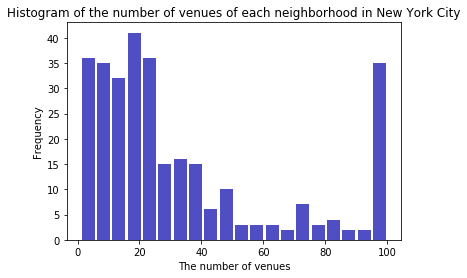

In [16]:
plt.hist(x=ind.values, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('The number of venues')
plt.ylabel('Frequency')
plt.title('Histogram of the number of venues of each neighborhood in New York City')
plt.show()

From histogram, we find neighborhoods with 95-100 venues or with 1-25 venues have higher frequency.

In [17]:
print(len(ind[ind.values>=95]))
print(len(ind[ind.values<=25]))

35
180


There are 35 Neighborhoods with 95-100 venues and 180 Neighborhoods with 1-25 venues.

We visualize these neighborhoods in the map:

In [19]:
NY100 = ind[ind.values>=95].index.tolist()
NY25 = ind[ind.values<=25].index.tolist()
NY100_dataset = NY_dataset[NY_dataset.Neighborhood.isin(NY100)]
NY25_dataset = NY_dataset[NY_dataset.Neighborhood.isin(NY25)]

In [20]:
NY100_map = folium.Map(location=[40.75, -74.0060152], zoom_start=11)

for lat, lng, neighborhood in zip(NY100_dataset['Latitude'], NY100_dataset['Longitude'], NY100_dataset['Neighborhood']):
    neighborhood = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=neighborhood,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NY100_map)  

NY100_map

For neighborhoods with 95-100 venues, we find most of them are in borough *Manhattan*. Also, the others are in boroughs like *Brooklyn* and *Queens* that are very close to *Manhattan*. However, there is a special neighborhood *Belmont* in borough *Bronx*, which is far away from *Manhattan*.

In [21]:
NY25_map = folium.Map(location=[40.45, -73.8], zoom_start=9)

for lat, lng, neighborhood in zip(NY25_dataset['Latitude'], NY25_dataset['Longitude'], NY25_dataset['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    color = 'blue'
    if neighborhood == 'Manhattan, Stuyvesant Town':
        color = 'red'
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NY25_map) 

NY25_map

For neighborhoods with 1-25 venues, we find most of them are spread around the New York City except borough *Manhattan*. There is only a neighborhood *Stuyvesant Town* in borough *Manhattan*.

## Toronto data

In [22]:
TO_dataset.shape

(138, 3)

In [23]:
TO_dataset.columns

Index(['Neighborhood', 'Latitude', 'Longitude'], dtype='object')

City of Toronto dataset has 138 observations (unique neighborhoods) and 3 variables *Neighborhood*, *Latitude*, and *Longitude*.

In [24]:
TO_venues.shape

(2130, 7)

In [25]:
TO_venues.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

In [26]:
len(TO_venues['Neighborhood'].unique())

138

In [27]:
len(TO_venues['Venue Category'].unique())

282

In [28]:
len(TO_venues['Venue'].unique())

1654

City of Toronto venues dataset has 2130 observations and 7 variables *Neighborhood*, *Neighborhood Latitude*, *Neighborhood Longitude*, *Venue*, *Venue Latitude*, *Venue Longitude*, *Venue Category*.

There are 138 unique neighborhood which matches the number of unique neighborhoods in City of Toronto dataset.

Also, the unique number of venues categories is 282 and the unique number of venues is 1654. This indicates there are some venues sharing the same name or they are chain stores.

Summary of City of Toronto dataset.

The number of each venue is:

In [29]:
TO_venues.Venue.value_counts()[:10]

Tim Hortons           62
Subway                43
Starbucks             35
Pizza Pizza           27
TD Canada Trust       25
Shoppers Drug Mart    22
Dollarama             14
McDonald's            13
The Beer Store        13
Second Cup            12
Name: Venue, dtype: int64

The first ten most common venues in City of Toronto are *Tim Hortons*, *Subway*, *Starbucks*, *Pizza Pizza*, *TD Canada Trust*, *Shoppers Drug Mart*, *Dollarama*, *The Beer Store*, *McDonald's*, *LCBO*.

We find seven of them are related to food, one of them is bank, one of them is drugstore, and the other one of them is market.

The number of each venue category is:

In [30]:
TO_venues['Venue Category'].value_counts()[:10]

Coffee Shop             151
Park                     89
Café                     80
Pizza Place              76
Sandwich Place           63
Italian Restaurant       58
Fast Food Restaurant     45
Grocery Store            42
Bakery                   41
Bar                      41
Name: Venue Category, dtype: int64

The first tem most common venue categories in City of Toronto are *Coffee Shop, Park, Cafe, Pizza Place, Sandwich Place, Italian Restaurant, Fast Food Restaurant, Grocery Store, Bakery, Bar*.

We find nine of them are related to food (include grocery store) and the other one is park.

Also, we are interested in the number of venues for each neighborhood:

In [31]:
ind = TO_venues.Neighborhood.value_counts()

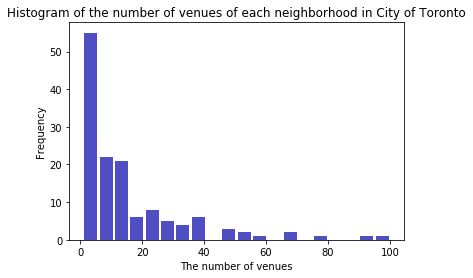

In [32]:
plt.hist(x=ind.values, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlabel('The number of venues')
plt.ylabel('Frequency')
plt.title('Histogram of the number of venues of each neighborhood in City of Toronto')
plt.show()

From histogram, we find neighborhoods with 1-5 venues have higher frequency.

In [34]:
len(ind[ind.values<=5])

55

There are 55 neighborhoods have 1-5 venues.

We are also interested in the neighborhoods with 90-100 venues.

In [37]:
len(ind[ind.values>=90])

2

Only 2 neighborhoods have 90-100 venues.

We visualize these neighborhoods in the map:

In [38]:
TO90 = ind[ind.values>=90].index.tolist()
TO5 = ind[ind.values<=5].index.tolist()
TO90_dataset = TO_dataset[TO_dataset.Neighborhood.isin(TO90)]
TO5_dataset = TO_dataset[TO_dataset.Neighborhood.isin(TO5)]

In [39]:
TO_map = folium.Map(location=[43.73, -79.38], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(TO90_dataset['Latitude'], TO90_dataset['Longitude'], TO90_dataset['Neighborhood']):
    neighborhood = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=neighborhood,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(TO_map)  
    
for lat, lng, neighborhood in zip(TO5_dataset['Latitude'], TO5_dataset['Longitude'], TO5_dataset['Neighborhood']):
    neighborhood = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=neighborhood,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(TO_map) 
    
TO_map

The neighborhoods with 90-100 venues are in the downtown of Toronto.

# Clustering Analysis

## Combine the data

Combine New York City dataset with City of Toronto dataset.

In [40]:
comb_dataset = pd.concat([NY_dataset, TO_dataset], ignore_index=True, axis=0)
comb_dataset.head()

,Neighborhood,Latitude,Longitude
0,"Bronx, Wakefield",40.894705,-73.847201
1,"Bronx, Co-op City",40.874294,-73.829939
2,"Bronx, Eastchester",40.887556,-73.827806
3,"Bronx, Fieldston",40.895437,-73.905643
4,"Bronx, Riverdale",40.890834,-73.912585


In [41]:
comb_dataset.shape

(444, 3)

Combine New York City venues data with City of Toronto venues data.

In [42]:
comb_venues = pd.concat([NY_venues, TO_venues], ignore_index=True, axis=0)
comb_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bronx, Wakefield",40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,"Bronx, Wakefield",40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,"Bronx, Wakefield",40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,"Bronx, Wakefield",40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,"Bronx, Wakefield",40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [43]:
comb_venues.shape

(12363, 7)

Modify the dataset using one-hot encoding.

In [44]:
# one hot encoding
comb_onehot = pd.get_dummies(comb_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
comb_onehot['neighborhood'] = comb_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [comb_onehot.columns[-1]] + list(comb_onehot.columns[:-1])
comb_onehot = comb_onehot[fixed_columns]

In [45]:
comb_onehot.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Bronx, Wakefield",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Bronx, Wakefield",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bronx, Wakefield",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Bronx, Wakefield",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bronx, Wakefield",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
comb_onehot.shape

(12363, 466)

There are 466 features (venue categories) of neighborhoods in combined data.

Acquire the average frequency of occurrence of each category for neighborhoods.

In [47]:
comb_grouped = comb_onehot.groupby('neighborhood').mean().reset_index()
comb_grouped.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0
1,Agincourt South-Malvern West,0.000000,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Alderwood,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Annex,0.000000,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Banbury-Don Mills,0.045455,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [48]:
comb_grouped.shape

(444, 466)

The first 10 most common venue categories for each neighborhood.

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = comb_grouped['neighborhood']

for ind in np.arange(comb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(comb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Chinese Restaurant,Park,Convenience Store,Sandwich Place,Pizza Place,Liquor Store,Bakery,Discount Store,Dim Sum Restaurant,Vietnamese Restaurant
1,Agincourt South-Malvern West,Chinese Restaurant,Shopping Mall,Malay Restaurant,Dim Sum Restaurant,Mediterranean Restaurant,Bank,Seafood Restaurant,Filipino Restaurant,Asian Restaurant,Cantonese Restaurant
2,Alderwood,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Pharmacy,Zoo Exhibit,Event Service,Event Space,Exhibit,Eye Doctor
3,Annex,Sandwich Place,Pub,Café,BBQ Joint,Donut Shop,Social Club,Pizza Place,Vegetarian / Vegan Restaurant,Liquor Store,Pharmacy
4,Banbury-Don Mills,Gourmet Shop,Shoe Store,Coffee Shop,Liquor Store,Shopping Mall,Sandwich Place,Pizza Place,Pharmacy,Movie Theater,Italian Restaurant


In [51]:
neighborhoods_venues_sorted.shape

(444, 11)

## K-means

Compute reconstruction error and draw scree plot to decide the best *K*.

In [103]:
comb_grouped2 = comb_grouped.drop('neighborhood', 1)
k_list = range(1,21)
SSE = []

for k in k_list:
    mod = KMeans(n_clusters=k, init='k-means++', random_state=0)
    mod.fit(comb_grouped2)
    SSE.append(mod.inertia_)

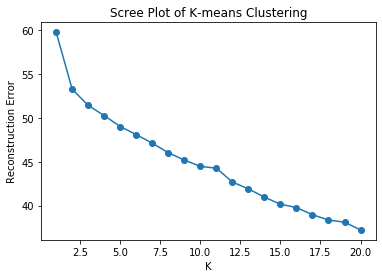

In [105]:
plt.plot(k_list, SSE, 'o-')
plt.title('Scree Plot of K-means Clustering')
plt.ylabel('Reconstruction Error')
plt.xlabel('K')
plt.show()

From the scree plot, there is a drastic drop from K=1 to K=2. We choose K=3 conservatively.

In [54]:
mod = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(comb_grouped2)

Add clustering results as a variable into *neighborhoods_venues_sorted* dataset.

In [55]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', mod.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Agincourt North,Chinese Restaurant,Park,Convenience Store,Sandwich Place,Pizza Place,Liquor Store,Bakery,Discount Store,Dim Sum Restaurant,Vietnamese Restaurant
1,0,Agincourt South-Malvern West,Chinese Restaurant,Shopping Mall,Malay Restaurant,Dim Sum Restaurant,Mediterranean Restaurant,Bank,Seafood Restaurant,Filipino Restaurant,Asian Restaurant,Cantonese Restaurant
2,0,Alderwood,Pizza Place,Athletics & Sports,Coffee Shop,Convenience Store,Pharmacy,Zoo Exhibit,Event Service,Event Space,Exhibit,Eye Doctor
3,0,Annex,Sandwich Place,Pub,Café,BBQ Joint,Donut Shop,Social Club,Pizza Place,Vegetarian / Vegan Restaurant,Liquor Store,Pharmacy
4,0,Banbury-Don Mills,Gourmet Shop,Shoe Store,Coffee Shop,Liquor Store,Shopping Mall,Sandwich Place,Pizza Place,Pharmacy,Movie Theater,Italian Restaurant


Add variable neighborhood from *comb_dataset* dataset into *neighborhoods_venues_sorted* dataset.

In [56]:
comb_dataset2 = comb_dataset.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [114]:
comb_dataset2.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bronx, Wakefield",40.894705,-73.847201,0,Pharmacy,Deli / Bodega,Laundromat,Sandwich Place,Dessert Shop,Gas Station,Ice Cream Shop,Donut Shop,Falafel Restaurant,Factory
1,"Bronx, Co-op City",40.874294,-73.829939,0,Bus Station,Fast Food Restaurant,Baseball Field,Discount Store,Park,Grocery Store,Mattress Store,Trail,Bagel Shop,Pizza Place
2,"Bronx, Eastchester",40.887556,-73.827806,0,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Intersection,Bowling Alley,Bakery,Chinese Restaurant,Fast Food Restaurant,Seafood Restaurant
3,"Bronx, Fieldston",40.895437,-73.905643,0,River,Bus Station,Plaza,Zoo Exhibit,Film Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory
4,"Bronx, Riverdale",40.890834,-73.912585,0,Bus Station,Park,Plaza,Gym,Baseball Field,Food Truck,Bank,Home Service,Playground,Field


Examine observations that clustering result = 0.

In [115]:
class1 = comb_dataset2.loc[comb_dataset2['Cluster Labels'] == 0,]

In [116]:
class1.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bronx, Wakefield",40.894705,-73.847201,0,Pharmacy,Deli / Bodega,Laundromat,Sandwich Place,Dessert Shop,Gas Station,Ice Cream Shop,Donut Shop,Falafel Restaurant,Factory
1,"Bronx, Co-op City",40.874294,-73.829939,0,Bus Station,Fast Food Restaurant,Baseball Field,Discount Store,Park,Grocery Store,Mattress Store,Trail,Bagel Shop,Pizza Place
2,"Bronx, Eastchester",40.887556,-73.827806,0,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Intersection,Bowling Alley,Bakery,Chinese Restaurant,Fast Food Restaurant,Seafood Restaurant
3,"Bronx, Fieldston",40.895437,-73.905643,0,River,Bus Station,Plaza,Zoo Exhibit,Film Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory
4,"Bronx, Riverdale",40.890834,-73.912585,0,Bus Station,Park,Plaza,Gym,Baseball Field,Food Truck,Bank,Home Service,Playground,Field


In [117]:
class1.shape

(404, 14)

In [118]:
str(class1.Neighborhood.values).count(',')

288

For 'cluster label = 0' group, there are 404 neighborhoods. 288 of them are from New York City.

In [119]:
# Function takes a dataframe and returns a dataframe of modes for each feature
def find_mode(data):
    # instantiate the dataframe
    venues_mode = pd.DataFrame()

    for ind in range(data.shape[1]):
        data2 = data.iloc[:,ind].value_counts()
        
        if data2.min() == 1:
            # index of the frist value = 1
            mini = np.where(data2.values==1)[0][0]
        else:
            mini = len(data2)
    
        values_list = data2.values[0:mini].tolist()
        index_list = data2.index[0:mini].tolist()
    
        # list comprehension
        comb_list = [str(index_list[i]) + ' ' + str(values_list[i]) for i in range(len(index_list))]
        #comb_list = [str(index_list[i]) for i in range(len(index_list))]
        venues_mode = pd.concat([venues_mode, pd.DataFrame(comb_list)], ignore_index=True, axis=1)
    venues_mode.columns = data.columns
    return(venues_mode)

In [120]:
class1_drop = class1.drop(['Neighborhood','Latitude','Longitude','Cluster Labels'], axis=1)
find_mode(class1_drop)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Italian Restaurant,Italian Restaurant,Pizza Place,Pizza Place,Pizza Place,Pizza Place,Exhibit,Eye Doctor,Eye Doctor,Factory
1,Pizza Place,Pizza Place,Coffee Shop,Sandwich Place,Coffee Shop,Donut Shop,Event Space,Exhibit,Factory,Falafel Restaurant
2,Coffee Shop,Coffee Shop,Bank,Bakery,Park,Exhibit,Pizza Place,Pharmacy,Falafel Restaurant,Eye Doctor
3,Bar,Deli / Bodega,Deli / Bodega,Donut Shop,Zoo Exhibit,Event Space,Bakery,Chinese Restaurant,Exhibit,Farm
4,Deli / Bodega,Grocery Store,Park,Chinese Restaurant,Chinese Restaurant,Sandwich Place,Eye Doctor,Event Space,Bakery,Bar
5,Pharmacy,Park,Café,Bar,Bakery,Coffee Shop,Pharmacy,Fast Food Restaurant,Pizza Place,Farmers Market
6,Chinese Restaurant,Café,Chinese Restaurant,American Restaurant,Pharmacy,Bank,Coffee Shop,Sandwich Place,Chinese Restaurant,Coffee Shop
7,Café,Pharmacy,Sandwich Place,Zoo Exhibit,Fast Food Restaurant,Grocery Store,Fast Food Restaurant,Factory,Park,Pharmacy
8,Caribbean Restaurant,Bus Station,Bakery,Playground,Bank,Pharmacy,Donut Shop,Falafel Restaurant,Sandwich Place,Gym / Fitness Center
9,Park,Fast Food Restaurant,Grocery Store,Grocery Store,Donut Shop,Park,Chinese Restaurant,Pizza Place,Farm,Grocery Store


The important characteristics of these neighborhoods are Italian restaurant and Pizza place. We conclude that people in these neighborhoods pay more attention on food especially Italian cuisine.

Examine observations that clustering result = 1.

In [121]:
class2 = comb_dataset2.loc[comb_dataset2['Cluster Labels'] == 1,]

In [122]:
class2.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,"Bronx, Clason Point",40.806551,-73.854144,1,Park,Bus Stop,Grocery Store,Boat or Ferry,South American Restaurant,Pool,Zoo Exhibit,Film Studio,Eye Doctor,Factory
192,"Queens, Somerville",40.597711,-73.796648,1,Park,Zoo Exhibit,Financial or Legal Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
203,"Staten Island, Todt Hill",40.597069,-74.111329,1,Park,Zoo Exhibit,Financial or Legal Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
303,"Queens, Bayswater",40.611322,-73.765968,1,Tennis Court,Park,Playground,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
306,Wychwood,43.676919,-79.425515,1,Park,Italian Restaurant,Event Space,Farmers Market,Financial or Legal Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm


In [123]:
class2.shape

(26, 14)

In [124]:
str(class2.Neighborhood.values).count(',')

4

For 'cluster label = 1' group, there are 26 neighborhoods. 4 of them are from New York City.

In [125]:
class2_drop = class2.drop(['Neighborhood','Latitude','Longitude','Cluster Labels'], axis=1)
find_mode(class2_drop)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Park,Park,Zoo Exhibit,Zoo Exhibit,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
1,NaN,Zoo Exhibit,Financial or Legal Service,Film Studio,Film Studio,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
2,NaN,Pool,Park,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
3,NaN,Mobile Phone Shop,Dog Run,NaN,Financial or Legal Service,NaN,NaN,NaN,Eye Doctor,Factory
4,NaN,NaN,NaN,NaN,Event Service,NaN,NaN,NaN,NaN,NaN


The important venue categories shared by these neighborhoods are Park and Zoo Exhibit. We conclude that neighborhoods in this group provide individuals with places that connect with nature.

Examine observations that clustering result = 2.

In [126]:
class3 = comb_dataset2.loc[comb_dataset2['Cluster Labels'] == 2,]

In [127]:
class3.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
198,"Staten Island, New Brighton",40.640615,-74.087017,2,Bus Stop,Park,Bowling Alley,Discount Store,Playground,Zoo Exhibit,Financial or Legal Service,Eye Doctor,Factory,Falafel Restaurant
202,"Staten Island, Grymes Hill",40.624185,-74.087248,2,Bus Stop,Dog Run,Zoo Exhibit,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
212,"Staten Island, Oakwood",40.558462,-74.121566,2,Bus Stop,Lawyer,Bar,Zoo Exhibit,Financial or Legal Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant
219,"Staten Island, Silver Lake",40.619193,-74.096290,2,Burger Joint,American Restaurant,Bus Stop,Golf Course,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
224,"Staten Island, Park Hill",40.609190,-74.080157,2,Bus Stop,Coffee Shop,Gym / Fitness Center,Hotel,Athletics & Sports,Zoo Exhibit,Film Studio,Exhibit,Eye Doctor,Factory


In [128]:
class3.shape

(14, 14)

In [129]:
str(class3.Neighborhood.values).count(',')

14

For 'cluster label = 2' group, there are 14 neighborhoods. all of them are from New York City.

In [130]:
class3_drop = class3.drop(['Neighborhood','Latitude','Longitude','Cluster Labels'], axis=1)
find_mode(class3_drop)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bus Stop,Coffee Shop,Pizza Place,Zoo Exhibit,Financial or Legal Service,Event Space,Exhibit,Factory,Factory,Falafel Restaurant
1,NaN,American Restaurant,NaN,Pizza Place,Fish & Chips Shop,Zoo Exhibit,Eye Doctor,Eye Doctor,Falafel Restaurant,Farm
2,NaN,NaN,NaN,NaN,Zoo Exhibit,Exhibit,Film Studio,Exhibit,Eye Doctor,Factory
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Exhibit,NaN


The important features of these neighborhoods are bus stops and restaruants. Also, there are various exhibitions and provide financial/legal services. It seems they are integrated area, where people get off the bus here and eat some food, visit exhibitions, and use financial services.

Visualize K-means results on the map.

In [74]:
NY_cluster = comb_dataset2[:306]

In [75]:
NY_cluster_map = folium.Map(location=[40.75, -74.0060152], zoom_start=10)

for lat, lng, neighborhood, cluster in zip(NY_cluster['Latitude'], NY_cluster['Longitude'], NY_cluster['Neighborhood'], NY_cluster['Cluster Labels']):
    neighborhood = folium.Popup(neighborhood, parse_html=True)
    
    if cluster == 0:
        color = 'red'
    elif cluster == 1:
        color = 'blue'
    else:
        color = 'green'
        
    folium.CircleMarker(
        location=[lat, lng],
        radius=4,
        popup=neighborhood,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_cluster_map)  

NY_cluster_map

In [76]:
TO_cluster = comb_dataset2[306:]

In [77]:
TO_cluster_map = folium.Map(location=[43.73, -79.38], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, cluster in zip(TO_cluster['Latitude'], TO_cluster['Longitude'], TO_cluster['Neighborhood'], TO_cluster['Cluster Labels']):
    neighborhood = folium.Popup(neighborhood, parse_html=True)
    
    if cluster == 0:
        color = 'red'
    elif cluster == 1:
        color = 'blue'
    else:
        color = 'green'
        
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=neighborhood,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(TO_cluster_map)  
    
TO_cluster_map

## Non-negative Matrix Factorization (NMF) + K-means

Since the combined dataset has 444 observations (neighborhoods) and 465 features (venue categories). It is a sparse data matrix. Also, there are more features than observations, so it is high-dimensional.

In order to solve these two problems simultaneously, we conduct NMF first and then perform K-means clustering.

Also, unlike the combination of PCA and K-means, which creates new features by mixing all the original features (venue categories) together, the advantage of combination of NMF and K-means is that it keeps all the orginal features.

### Non-negative Matrix Factorization (NMF):

In [106]:
k_list = range(1,11)
err = []
for i in k_list:
    mod = NMF(n_components=i)
    mod.fit(comb_grouped2.to_numpy())
    err.append(mod.reconstruction_err_)

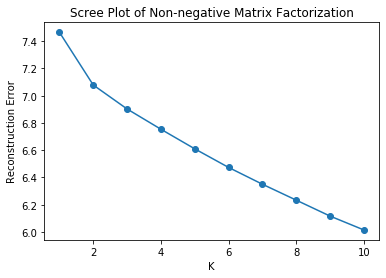

In [107]:
plt.plot(k_list, err, 'o-')
plt.title('Scree Plot of Non-negative Matrix Factorization')
plt.ylabel('Reconstruction Error')
plt.xlabel('K')
plt.show()

From the scree plot, the elbow point is at K=2, we select K=3 conservatively.

In [80]:
mod = NMF(n_components=3)
W = mod.fit_transform(comb_grouped2.to_numpy())
H = mod.components_

The features segmentation of NMF.

In [81]:
for i in range(0,3):
    tmp = pd.DataFrame(H[i,])
    tmp['name'] = comb_grouped2.columns
    print(tmp.sort_values(by=[0], ascending=False).name.values[:10])

['Park' 'Playground' 'Pool' 'Mobile Phone Shop' 'Home Service' 'Theater'
 'Gym / Fitness Center' 'Residential Building (Apartment / Condo)'
 'Dog Run' 'Soccer Field']
['Pizza Place' 'Coffee Shop' 'Pharmacy' 'Sandwich Place'
 'Chinese Restaurant' 'Grocery Store' 'Italian Restaurant' 'Deli / Bodega'
 'Bank' 'Donut Shop']
['Bus Stop' 'Deli / Bodega' 'Dog Run' 'American Restaurant' 'Beach'
 'Intersection' 'Italian Restaurant' 'Bagel Shop' 'Playground' 'Lawyer']


NMF creates three groups by weighting 465 features into . By looking at first 10 most important features in each group, we find features in each group share characteristics. 

Features in group 1 are related to exercise and living. For group 2, features are related to food. Most features in group3 are related to transportation, food, and recreation area.

### K-means clustering:

In [82]:
comb_grouped2_NMF = pd.DataFrame(W)

In [83]:
k_list = range(1,21)
SSE = []

for k in k_list:
    mod = KMeans(n_clusters=k, init='k-means++', random_state=0)
    mod.fit(comb_grouped2_NMF)
    SSE.append(mod.inertia_)

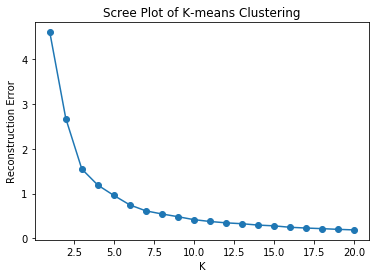

In [84]:
plt.plot(k_list, SSE, 'o-')
plt.title('Scree Plot of K-means Clustering')
plt.ylabel('Reconstruction Error')
plt.xlabel('K')
plt.show()

From scree plot, the elbow point is at K=3. In order to compare it with previous K-means clustering, we select K=3.

In [85]:
mod = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(comb_grouped2_NMF)

In [86]:
comb_dataset3 = comb_dataset2.copy()
comb_dataset3.insert(4, 'Cluster Labels2', mod.labels_)

In [131]:
comb_dataset3.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bronx, Wakefield",40.894705,-73.847201,0,1,Pharmacy,Deli / Bodega,Laundromat,Sandwich Place,Dessert Shop,Gas Station,Ice Cream Shop,Donut Shop,Falafel Restaurant,Factory
1,"Bronx, Co-op City",40.874294,-73.829939,0,1,Bus Station,Fast Food Restaurant,Baseball Field,Discount Store,Park,Grocery Store,Mattress Store,Trail,Bagel Shop,Pizza Place
2,"Bronx, Eastchester",40.887556,-73.827806,0,1,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Intersection,Bowling Alley,Bakery,Chinese Restaurant,Fast Food Restaurant,Seafood Restaurant
3,"Bronx, Fieldston",40.895437,-73.905643,0,1,River,Bus Station,Plaza,Zoo Exhibit,Film Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory
4,"Bronx, Riverdale",40.890834,-73.912585,0,1,Bus Station,Park,Plaza,Gym,Baseball Field,Food Truck,Bank,Home Service,Playground,Field


Examine observations that clustering result = 0.

In [132]:
class1 = comb_dataset3.loc[comb_dataset3['Cluster Labels2'] == 0,]

In [133]:
class1.shape

(23, 15)

In [134]:
str(class1.Neighborhood.values).count(',')

3

For 'cluster label = 0' group, there are 23 neighborhoods. 3 of them are from New York City.

In [135]:
class1_drop = class1.drop(['Neighborhood','Latitude','Longitude','Cluster Labels','Cluster Labels2'], axis=1)
find_mode(class1_drop)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Park,Park,Coffee Shop,Zoo Exhibit,Pizza Place,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
1,Italian Restaurant,Bakery,Café,Breakfast Spot,Event Space,Zoo Exhibit,Exhibit,Eye Doctor,Factory,Falafel Restaurant
2,Indian Restaurant,Grocery Store,Zoo Exhibit,Film Studio,Financial or Legal Service,Event Space,Thai Restaurant,Event Space,Exhibit,Eye Doctor
3,Café,Coffee Shop,NaN,NaN,Zoo Exhibit,NaN,NaN,NaN,NaN,Chinese Restaurant
4,Chinese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The important venue categories shared by these neighborhoods are Park, coffee shop and Zoo Exhibit. We conclude that these neighborhoods provide people with places that connect with nature. Also, coffee shop seems a complementary place for the rest when individuals get tired.

Examine observations that clustering result = 1.

In [136]:
class2 = comb_dataset3.loc[comb_dataset3['Cluster Labels2'] == 1,]

In [137]:
class2.shape

(390, 15)

In [94]:
str(class2.Neighborhood.values).count(',')

279

For 'cluster label = 1' group, there are 390 neighborhoods. 279 of them are from New York City.

In [138]:
class2_drop = class2.drop(['Neighborhood','Latitude','Longitude','Cluster Labels','Cluster Labels2'], axis=1)
find_mode(class2_drop)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Italian Restaurant,Italian Restaurant,Pizza Place,Pizza Place,Pizza Place,Exhibit,Exhibit,Eye Doctor,Factory,Falafel Restaurant
1,Pizza Place,Coffee Shop,Park,Zoo Exhibit,Coffee Shop,Event Space,Eye Doctor,Factory,Falafel Restaurant,Factory
2,Coffee Shop,Pizza Place,Coffee Shop,Sandwich Place,Film Studio,Pizza Place,Event Space,Exhibit,Eye Doctor,Farm
3,Park,Deli / Bodega,Deli / Bodega,Bakery,Chinese Restaurant,Eye Doctor,Pizza Place,Falafel Restaurant,Farm,Farmers Market
4,Bus Stop,Park,Bank,Event Space,Event Space,Donut Shop,Factory,Pharmacy,Exhibit,Eye Doctor
5,Bar,Café,Bakery,Donut Shop,Exhibit,Sandwich Place,Bakery,Chinese Restaurant,Bakery,Coffee Shop
6,Deli / Bodega,Zoo Exhibit,Sandwich Place,Bar,Park,Coffee Shop,Pharmacy,Event Space,Sandwich Place,Bar
7,Pharmacy,Bus Station,Grocery Store,Coffee Shop,Zoo Exhibit,Deli / Bodega,Bagel Shop,Sandwich Place,Pizza Place,Pharmacy
8,Caribbean Restaurant,Chinese Restaurant,Playground,American Restaurant,Bank,Caribbean Restaurant,Fast Food Restaurant,Fast Food Restaurant,Park,Grocery Store
9,Bank,Grocery Store,Café,Café,Bakery,Pharmacy,Chinese Restaurant,Restaurant,Chinese Restaurant,Sandwich Place


The important characteristics of these neighborhoods are Italian restaurant, Pizza place, and Exhibit. We conclude that these neighborhoods provide people with food, especially Italian cuisine. Also, these neighborhoods have a lot of exhibitions

Examine observations that clustering result = 2.

In [139]:
class3 = comb_dataset3.loc[comb_dataset3['Cluster Labels2'] == 2,]

In [140]:
class3.shape

(31, 15)

In [98]:
str(class3.Neighborhood.values).count(',')

24

For 'cluster label = 2' group, there are 31 neighborhoods. 24 of them are from New York City.

In [141]:
class3_drop = class3.drop(['Neighborhood','Latitude','Longitude','Cluster Labels','Cluster Labels2'], axis=1)
find_mode(class3_drop)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pizza Place,Pizza Place,Chinese Restaurant,Deli / Bodega,Pharmacy,Bank,Donut Shop,Fast Food Restaurant,Middle Eastern Restaurant,Falafel Restaurant
1,Coffee Shop,Grocery Store,Sandwich Place,Gym,Zoo Exhibit,Event Space,Exhibit,Chinese Restaurant,Factory,Eye Doctor
2,Bus Station,Donut Shop,Bus Stop,Pizza Place,Fried Chicken Joint,Filipino Restaurant,Bakery,Eye Doctor,Fast Food Restaurant,Gym / Fitness Center
3,Bakery,Cosmetics Shop,Bank,Chinese Restaurant,Mobile Phone Shop,NaN,NaN,Donut Shop,Exhibit,Pet Store
4,Italian Restaurant,Pharmacy,NaN,NaN,NaN,NaN,NaN,NaN,Food Truck,NaN
5,Pharmacy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Chinese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most features are related to food. We concolude that these neighborhoods provides people with different kinds of food.

Visualize K-means results on the map.

In [100]:
NY_cluster = comb_dataset3[:306]

NY_cluster_map = folium.Map(location=[40.75, -74.0060152], zoom_start=10)

for lat, lng, neighborhood, cluster in zip(NY_cluster['Latitude'], NY_cluster['Longitude'], NY_cluster['Neighborhood'], NY_cluster['Cluster Labels2']):
    neighborhood = folium.Popup(neighborhood, parse_html=True)
    
    if cluster == 0:
        color = 'red'
    elif cluster == 1:
        color = 'blue'
    else:
        color = 'green'
        
    folium.CircleMarker(
        location=[lat, lng],
        radius=4,
        popup=neighborhood,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(NY_cluster_map)  

NY_cluster_map

In [101]:
TO_cluster = comb_dataset3[306:]

TO_cluster_map = folium.Map(location=[43.73, -79.38], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, cluster in zip(TO_cluster['Latitude'], TO_cluster['Longitude'], TO_cluster['Neighborhood'], TO_cluster['Cluster Labels2']):
    neighborhood = folium.Popup(neighborhood, parse_html=True)
    
    if cluster == 0:
        color = 'red'
    elif cluster == 1:
        color = 'blue'
    else:
        color = 'green'
        
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=neighborhood,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(TO_cluster_map)  
    
TO_cluster_map

## Comparison of two clustering methods

K-means clustering and NMF + K-means clustering share two groups, whcich are interpreted as neighborhoods with lots of Italian cuisine, and neighborhoods connecting with nature. The only difference is that the last group in K-means clustering has neighborhoods with multiple functions while that in NMF + K-means has neighoborhoods with various kinds of food.

In [143]:
map1 = folium.Map(location=[43.73, -79.38], zoom_start=10)
map1